In [1]:
import numpy as np
from numpy import random
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def predicted_real(predicted, real):
    plt.scatter(real, predicted, c='blue')
    p1 = max(max(predicted), max(real))
    p2 = min(min(predicted), min(real))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True values')
    plt.ylabel('Predictions')
    plt.title('Predictions visualization on test set')
    plt.axis('equal')
    plt.show()
    
def sigmoid(x):
    "Stabilna funkcja sigmoidalna"""
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        z = np.exp(x)
        return z / (1 + z)
sigmoid = np.vectorize(sigmoid)

def sigmoid_der(x):
    """Pochodna funkcji sigmoidalnej"""
    return sigmoid(x)*(1-sigmoid(x))
sigmoid_der = np.vectorize(sigmoid_der)

def MSE(predicted, real):
    return np.mean((predicted - real)**2)

def MAE(predicted, real):
    return np.mean(np.abs(predicted - real))

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def prepear_data(df_train, df_test):
    #Separacja wektorów cech i odpowiedzi
    x_train, x_test = df_train.iloc[:, 1], df_test.iloc[:, 1]
    x_train, x_test = np.array(x_train), np.array(x_test)
    #Implementacja wymaga "pionowego" wektora cech
    x_train.shape = (len(x_train), 1)
    x_test.shape = (len(x_test), 1)
    y_train, y_test = np.array(df_train.iloc[:, 2:3]), np.array(df_test.iloc[:, 2:3])
    #Normalizacja
    x_train, x_test = normalize(x_train), normalize(x_test)
    y_train, y_test = normalize(y_train), normalize(y_test)
    return x_train, y_train, x_test, y_test

In [3]:
class Layer:
        
    def __init__(self, 
                 #Liczba neuronów w poprzedzającej i kolejnej warstwie
                 input_size: int, 
                 output_size: int,
                 #Domyślna funkcja aktywacyjna i jej pochodna                 
                 activation_fun = sigmoid, 
                 activation_fun_der = sigmoid_der,
                 #Parametry rozkładu jednostajnego dla losowych wag
                 lb = -1,
                 ub = 1,
                 #Możliwe do ustawienia wagi i bias-y
                 weights = None, 
                 biases = None):
        
        #Domyślne losowo wygenerowane wagi i bias-y jeśli nie zostały podane
        d_weights = random.uniform(lb, ub, size = (output_size, input_size))
        d_biases = random.uniform(lb, ub, size = (output_size, 1))
        
        #Wagi dla wszystkich neuronów z warstwy 
        self.weights = weights if weights is not None else d_weights
        
        #Stałe "b"
        self.biases = biases if biases is not None else d_biases
        
        #Funkcja aktywacji i jej pochodna
        self.activation_fun = activation_fun
        self.activation_fun_der = activation_fun_der
    
    def predict(self, input):
        #Przekształca input z poprzedniej warstwy przez wagi i funkcję aktywacji 
        #Zwraca output do przekazania kolejnej warstwie
        return self.activation_fun(self.weights@input + self.biases)
    
    def forward(self, input):
        #Przekształca input z poprzedniej warstwy jedynie przez wagi
        return self.weights@input + self.biases

In [55]:
class Network:
    
    def __init__(self, layers: list):
        
        #Warstwy
        self.layers = layers
        self.momentum_w = [np.zeros(l.weights.shape) for l in layers]
        self.momentum_b = [np.zeros(l.biases.shape) for l in layers]
        self.g_w = [np.zeros(l.weights.shape) for l in layers]
        self.g_b = [np.zeros(l.biases.shape) for l in layers]
        
    def predict(self, X):
        """Oblicza output na podstawie danych i parametrów warstw"""
        output = X
        for layer in self.layers:
            output = layer.predict(output)
        return output
    
    def forward(self, X):
        """Pełna metoda feedforward
        return: sumy, aktywacje"""
        sums = []
        activations = [X]
        activations_layer = X
        for layer in self.layers:
            sums_layer = layer.forward(activations_layer)
            sums.append(sums_layer)
            
            activations_layer = layer.activation_fun(sums_layer)
            activations.append(activations_layer)
            
        return sums, activations
    
    def backprop(self, X, Y):
        """Propagacja wsteczna błędu
        return: gradienty MSE"""
        
        #Wyliczenie feedforward obecnymi parametrami
        sums, activations = self.forward(X)
        
        #Macierze na poprawki parametrów
        delta_biases = []
        delta_weights = []
        
        n_layers = len(self.layers)
        err = [None]*n_layers
        #Wyliczenie err ostatniej warstwy
        err[-1] = (Y - activations[-1])*self.layers[-1].activation_fun_der(sums[-1])
        
        #Wyliczenie gradientu MSE po parametrach ostatniej warstwy
        #delta_biases[-1] = err
        #delta_weights[-1] = activations[-2].transpose()@err
        
        #Propagacja wsteczna
        for i in range(n_layers-2, -1, -1):
            act_f_der = self.layers[i].activation_fun_der(sums[i])
            err[i] = (self.layers[i+1].weights.transpose()@err[i+1]) * act_f_der 
            
        #Batch size
        batch_size = Y.shape[1]
        delta_biases = [e@np.ones((batch_size, 1))/float(batch_size) 
                              for e in err]
        delta_weights = [np.dot(e, activations[i].transpose())/float(batch_size) 
                        for i, e in enumerate(err)]
        
        return delta_biases, delta_weights
    
    def train(self, X, Y, 
              batch_size = 1, 
              etha = 0.001, 
              tol = 10**(-6), 
              n_iter = 500, 
              #Lambda dla momentum
              l_m = 0,
              #Beta dla RMSProp
              beta = 1,
              verbose = False):
        """Wytrenowuje sieć wybraną metodą minimalizując MSE 
        na zbiorze walidacyjnym
        return: liczba epok (na potrzeby porównań)"""
        if(batch_size==1):
            algorithm = self.gd
        else:
            algorithm = self.batch_gd
            
        
        #Losowość przed podziałem zbioru, ziarno zapewnia identyczną permutację
        #w zmiennych objaśnających i zmiennej celu
        X = np.copy(x_train)
        Y = np.copy(y_train)
        random.RandomState(42).shuffle(X)
        random.RandomState(42).shuffle(Y)

        #Podział zbioru na część walidacyjną i treningową
        #proporcje: val 20% - train 80%
        X_split = np.split(X, [int(.8 * X.shape[1])], axis=1)
        X_train, X_val = X_split[0], X_split[1]

        Y_split = np.split(Y, [int(.8 * Y.shape[1])], axis=1)
        Y_train, Y_val = Y_split[0], Y_split[1]
        
        #Właściwe trenowanie sieci
        current_mse = np.inf
        new_mse = MSE(self.predict(X_val), Y_val)
        it = 1
        while True:
            #Wywołanie konkretnego algorytmu
            algorithm(X_train, Y_train, batch_size, etha, l_m, beta)
            new_mse = MSE(self.predict(X_val), Y_val)
            
            #Wizualizacja procesu uczenia
            if(verbose):
                print("Epoche " + str(it) + " finished")
                print("Current MSE on validation set:")
                print(new_mse)
                for i in range(len(self.layers)):
                    print("Warstwa " + str(i) + " wagi:")
                    print(self.layers[i].weights)
                    print("Warstwa " + str(i) + " bias-y:")
                    print(self.layers[i].biases)
                print("\n")
            
            it += 1
            if(it == n_iter):
                break
            elif(current_mse - new_mse > tol):
                current_mse = new_mse
            else:
                break
            
        return it
    
    def gd(self, X, Y, etha, l_m, beta):
        """Trening sieci podstawową metodą Gradient Descent"""
        b, w = self.backprop(X, Y)
        for i in range(len(self.layers)):
            #Aktualizacja momentum
            self.momentum_w[i] = w[i]+l_m*self.momentum_w[i]
            self.momentum_b[i] = b[i]+l_m*self.momentum_b[i]
            
            #Aktualizacja RMSProp
            self.g_w[i] = (1-beta)*w[i]*w[i]+beta*self.g_w[i]
            self.g_b[i] = (1-beta)*b[i]*b[i]+beta*self.g_b[i]
        
            l = self.layers[i]
            if(beta):
                l.biases = l.biases + etha*self.momentum_b[i] + (etha*b[i])/np.sqrt(0.00001+self.g_b[i]) 
                l.weights = l.weights + etha*self.momentum_w[i] + (etha*w[i])/np.sqrt(0.00001+self.g_w[i])
            else:
                l.biases = l.biases + etha*self.momentum_b[i]
                l.weights = l.weights + etha*self.momentum_w[i]
            
        return
    
    def batch_gd(self, X, Y, batch_size, etha, l_m, beta):
        """Trening sieci metodą Mini-batch Gradient Descent"""
        #Metoda train uprzednio dokonuje permutacji zbioru
        #Wywołanie metody gradient descent na kolejnych batch-ach
        i=0
        while(i<len(Y)):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            i += batch_size
            self.gd(x, y, etha, l_m, beta)
        return
        

In [64]:
df1_train = pd.read_csv("./mio1/regression/square-large-training.csv")
df1_test = pd.read_csv("./mio1/regression/square-large-test.csv")

df2_train = pd.read_csv("./mio1/regression/steps-large-training.csv")
df2_test = pd.read_csv("./mio1/regression/steps-large-test.csv")

df3_train = pd.read_csv("./mio1/regression/multimodal-large-training.csv")
df3_test = pd.read_csv("./mio1/regression/multimodal-large-test.csv")

In [66]:
#Te same koncepcje co w PD1-PD2
#Architektura 1
def arch1(lb = -1, ub = 1):
    l1_1 = Layer(input_size=1, output_size=5, lb = -1, ub = 1)
    l1_2 = Layer(input_size=5, output_size=1, lb = -1, ub = 1, 
               activation_fun= lambda x: x, 
               activation_fun_der= lambda x: 1)          
    return Network([l1_1, l1_2])
    
#Architektura 2
def arch2(lb = -1, ub = 1):
    l2_1 = Layer(1, 10, lb = -1, ub = 1)
    l2_2 = Layer(10, 1, lb = -1, ub = 1, 
                 activation_fun= lambda x: x, 
                 activation_fun_der= lambda x: 1)
    return Network([l2_1, l2_2])

#Architektura 3
def arch3(lb = -1, ub = 1):
    l3_1 = Layer(input_size=1, output_size=5, lb = -1, ub = 1)
    l3_2 = Layer(input_size=5, output_size=5, lb = -1, ub = 1)
    l3_3 = Layer(input_size=5, output_size=1, lb = -1, ub = 1,
               activation_fun= lambda x: x, 
               activation_fun_der= lambda x: 1)
    return Network([l3_1, l3_2, l3_3])

In [67]:
data_train = [df1_train, df2_train, df3_train]
data_test = [df1_test, df2_test, df3_test]

In [ ]:
r1 = np.zeros((2, 3))
r2 = np.zeros((2, 3))
r3 = np.zeros((2, 3))
j = 0
for df_train, df_test in zip(data_train, data_test):
    x_train, y_train, x_test, y_test = prepear_data(df_train, df_test)
    #Wykonam po n procesów trenowania sieci i uśrednię liczbę epok
    n = 5
    ep1 = np.zeros((n, 2))
    ep2 = np.zeros((n, 2))
    ep3 = np.zeros((n, 2))
    
    for i in range(n):
        mlp1 = arch1()
        mlp2 = arch2()
        mlp3 = arch3()
        
        ep1[i][0] = mlp1.train(x_train, y_train)
        ep2[i][0] = mlp2.train(x_train, y_train)
        ep3[i][0] = mlp3.train(x_train, y_train)
        
        mlp1 = arch1()
        mlp2 = arch2()
        mlp3 = arch3()
        
        ep1[i][1] = mlp1.train(x_train, y_train, k=5)
        ep2[i][1] = mlp2.train(x_train, y_train, k=5)
        ep3[i][1] = mlp3.train(x_train, y_train, k=5)
        
        mlp1 = arch1()
        mlp2 = arch2()
        mlp3 = arch3()
        
        ep1[i][1] = mlp1.train(x_train, y_train, k=5)
        ep2[i][1] = mlp2.train(x_train, y_train, k=5)
        ep3[i][1] = mlp3.train(x_train, y_train, k=5)
    
    r1[j] = np.mean(ep1, axis=0)
    r2[j] = np.mean(ep2, axis=0)
    r3[j] = np.mean(ep3, axis=0)
    j+=1
    print("DF " + str(j) + " finished")

In [68]:
x_train, y_train, x_test, y_test = prepear_data(df1_train, df1_test)

In [69]:
x_train = x_train.reshape(1, -1)
y_train = y_train.reshape(1,-1)
x_test = x_test.reshape(1,-1)
y_test = y_test.reshape(1,-1)

In [184]:
l1_1 = Layer(input_size=1, output_size=5, lb = -1, ub = 1)
l1_2 = Layer(input_size=5, output_size=1, lb = -1, ub = 1, 
               activation_fun= lambda x: x, 
               activation_fun_der= lambda x: 1)        
nn = Network([l1_1, l1_2])

In [104]:
nn.train(x_train, y_train, l_m = 0, beta = 0, tol=10**(-6), n_iter=10000, batch_size=20, etha=0.001, verbose=True)

Epoche 1 finished
Current MSE on validation set:
0.08799733376598116
Warstwa 0 wagi:
[[-0.7502613 ]
 [ 0.41942231]
 [ 0.34544471]
 [-0.47339895]
 [-0.99832133]]
Warstwa 0 bias-y:
[[ 0.65700165]
 [-0.18631472]
 [-0.38642093]
 [ 0.04002009]
 [-0.80956701]]
Warstwa 1 wagi:
[[-0.17183529  0.44690569 -0.77859648 -0.72003799  0.13469345]]
Warstwa 1 bias-y:
[[0.95763344]]


Epoche 2 finished
Current MSE on validation set:
0.087887350047792
Warstwa 0 wagi:
[[-0.75025911]
 [ 0.41941633]
 [ 0.34545486]
 [-0.47338925]
 [-0.99832277]]
Warstwa 0 bias-y:
[[ 0.65700874]
 [-0.1863339 ]
 [-0.38638817]
 [ 0.04005093]
 [-0.80957129]]
Warstwa 1 wagi:
[[-0.17193894  0.44682239 -0.77867028 -0.72011907  0.13465168]]
Warstwa 1 bias-y:
[[0.95746205]]


Epoche 3 finished
Current MSE on validation set:
0.0877778692460906
Warstwa 0 wagi:
[[-0.75025692]
 [ 0.41941036]
 [ 0.34546497]
 [-0.47337958]
 [-0.9983242 ]]
Warstwa 0 bias-y:
[[ 0.65701582]
 [-0.18635303]
 [-0.38635547]
 [ 0.04008172]
 [-0.80957556]]
Warstwa 

Epoche 25 finished
Current MSE on validation set:
0.08549215935728299
Warstwa 0 wagi:
[[-0.75021033]
 [ 0.41928427]
 [ 0.34567927]
 [-0.47317433]
 [-0.99835467]]
Warstwa 0 bias-y:
[[ 0.6571688 ]
 [-0.18676286]
 [-0.38565283]
 [ 0.0407435 ]
 [-0.80966703]]
Warstwa 1 wagi:
[[-0.17426558  0.44495701 -0.78032364 -0.721939    0.13371301]]
Warstwa 1 bias-y:
[[0.95362006]]


Epoche 26 finished
Current MSE on validation set:
0.08539365496308457
Warstwa 0 wagi:
[[-0.75020828]
 [ 0.41927876]
 [ 0.34568864]
 [-0.47316534]
 [-0.99835601]]
Warstwa 0 bias-y:
[[ 0.65717563]
 [-0.186781  ]
 [-0.38562165]
 [ 0.04077289]
 [-0.80967108]]
Warstwa 1 wagi:
[[-0.17436429  0.44487807 -0.78039364 -0.7220162   0.13367314]]
Warstwa 1 bias-y:
[[0.95345729]]


Epoche 27 finished
Current MSE on validation set:
0.08529560302644301
Warstwa 0 wagi:
[[-0.75020624]
 [ 0.41927328]
 [ 0.34569799]
 [-0.47315637]
 [-0.99835734]]
Warstwa 0 bias-y:
[[ 0.65718244]
 [-0.18679909]
 [-0.38559052]
 [ 0.04080223]
 [-0.80967512]]
Wa

Epoche 49 finished
Current MSE on validation set:
0.08324899070479976
Warstwa 0 wagi:
[[-0.7501628 ]
 [ 0.41915741]
 [ 0.34589581]
 [-0.47296609]
 [-0.99838581]]
Warstwa 0 bias-y:
[[ 0.65732968]
 [-0.18718675]
 [-0.38492183]
 [ 0.0414328 ]
 [-0.80976175]]
Warstwa 1 wagi:
[[-0.17658017  0.44311036 -0.78196175 -0.72374902  0.13277728]]
Warstwa 1 bias-y:
[[0.94980857]]


Epoche 50 finished
Current MSE on validation set:
0.08316081256472271
Warstwa 0 wagi:
[[-0.75016089]
 [ 0.41915235]
 [ 0.34590445]
 [-0.47295775]
 [-0.99838706]]
Warstwa 0 bias-y:
[[ 0.65733624]
 [-0.18720391]
 [-0.38489215]
 [ 0.0414608 ]
 [-0.80976559]]
Warstwa 1 wagi:
[[-0.17667419  0.44303555 -0.78202813 -0.72382253  0.13273923]]
Warstwa 1 bias-y:
[[0.94965399]]


Epoche 51 finished
Current MSE on validation set:
0.0830730413746636
Warstwa 0 wagi:
[[-0.75015899]
 [ 0.41914732]
 [ 0.34591307]
 [-0.47294945]
 [-0.99838831]]
Warstwa 0 bias-y:
[[ 0.6573428 ]
 [-0.18722102]
 [-0.38486254]
 [ 0.04148875]
 [-0.80976942]]
War

Epoche 73 finished
Current MSE on validation set:
0.08124147931942337
Warstwa 0 wagi:
[[-0.75011863]
 [ 0.41904108]
 [ 0.34609516]
 [-0.47277347]
 [-0.99841489]]
Warstwa 0 bias-y:
[[ 0.65748439]
 [-0.18758778]
 [-0.38422625]
 [ 0.0420895 ]
 [-0.80985151]]
Warstwa 1 wagi:
[[-0.1787848   0.4413606  -0.78351517 -0.7254725   0.13188402]]
Warstwa 1 bias-y:
[[0.94618893]]


Epoche 74 finished
Current MSE on validation set:
0.0811625876003354
Warstwa 0 wagi:
[[-0.75011686]
 [ 0.41903645]
 [ 0.34610311]
 [-0.47276578]
 [-0.99841606]]
Warstwa 0 bias-y:
[[ 0.6574907 ]
 [-0.18760402]
 [-0.38419801]
 [ 0.04211618]
 [-0.80985515]]
Warstwa 1 wagi:
[[-0.17887436  0.44128973 -0.78357812 -0.7255425   0.13184769]]
Warstwa 1 bias-y:
[[0.94604213]]


Epoche 75 finished
Current MSE on validation set:
0.08108406179676195
Warstwa 0 wagi:
[[-0.7501151 ]
 [ 0.41903184]
 [ 0.34611102]
 [-0.4727581 ]
 [-0.99841723]]
Warstwa 0 bias-y:
[[ 0.65749701]
 [-0.18762021]
 [-0.38416984]
 [ 0.0421428 ]
 [-0.80985878]]
War

Epoche 97 finished
Current MSE on validation set:
0.07944586631133566
Warstwa 0 wagi:
[[-0.75007776]
 [ 0.41893468]
 [ 0.34627811]
 [-0.47259578]
 [-0.99844204]]
Warstwa 0 bias-y:
[[ 0.65763305]
 [-0.18796726]
 [-0.38356447]
 [ 0.04271507]
 [-0.8099366 ]]
Warstwa 1 wagi:
[[-0.18088494  0.43970286 -0.78498805 -0.7271137   0.13103111]]
Warstwa 1 bias-y:
[[0.94275156]]


Epoche 98 finished
Current MSE on validation set:
0.07937532346956216
Warstwa 0 wagi:
[[-0.75007613]
 [ 0.41893045]
 [ 0.34628539]
 [-0.47258869]
 [-0.99844314]]
Warstwa 0 bias-y:
[[ 0.65763911]
 [-0.18798262]
 [-0.38353761]
 [ 0.04274049]
 [-0.80994005]]
Warstwa 1 wagi:
[[-0.18097025  0.43963572 -0.78504773 -0.72718036  0.13099642]]
Warstwa 1 bias-y:
[[0.94261216]]


Epoche 99 finished
Current MSE on validation set:
0.07930510954906958
Warstwa 0 wagi:
[[-0.7500745 ]
 [ 0.41892624]
 [ 0.34629264]
 [-0.47258163]
 [-0.99844422]]
Warstwa 0 bias-y:
[[ 0.65764517]
 [-0.18799795]
 [-0.3835108 ]
 [ 0.04276585]
 [-0.80994349]]
Wa

Epoche 121 finished
Current MSE on validation set:
0.07784073186753654
Warstwa 0 wagi:
[[-0.7500401 ]
 [ 0.41883765]
 [ 0.34644543]
 [-0.47243234]
 [-0.99846738]]
Warstwa 0 bias-y:
[[ 0.65777579]
 [-0.18832641]
 [-0.38293495]
 [ 0.04331093]
 [-0.81001731]]
Warstwa 1 wagi:
[[-0.18288577  0.43813252 -0.78638434 -0.72867665  0.13021654]]
Warstwa 1 bias-y:
[[0.9394874]]


Epoche 122 finished
Current MSE on validation set:
0.07777769274561837
Warstwa 0 wagi:
[[-0.7500386 ]
 [ 0.4188338 ]
 [ 0.34645207]
 [-0.47242583]
 [-0.9984684 ]]
Warstwa 0 bias-y:
[[ 0.65778161]
 [-0.18834095]
 [-0.38290939]
 [ 0.04333514]
 [-0.81002058]]
Warstwa 1 wagi:
[[-0.18296706  0.43806892 -0.78644091 -0.72874013  0.1301834 ]]
Warstwa 1 bias-y:
[[0.93935502]]


Epoche 123 finished
Current MSE on validation set:
0.07771494919955503
Warstwa 0 wagi:
[[-0.75003711]
 [ 0.41882997]
 [ 0.34645868]
 [-0.47241934]
 [-0.99846942]]
Warstwa 0 bias-y:
[[ 0.65778743]
 [-0.18835545]
 [-0.38288389]
 [ 0.04335929]
 [-0.81002385]]


Epoche 145 finished
Current MSE on validation set:
0.07640676863746268
Warstwa 0 wagi:
[[-0.75000557]
 [ 0.41874945]
 [ 0.34659782]
 [-0.47228249]
 [-0.99849102]]
Warstwa 0 bias-y:
[[ 0.65791276]
 [-0.18866637]
 [-0.38233618]
 [ 0.04387843]
 [-0.8100939 ]]
Warstwa 1 wagi:
[[-0.18479224  0.43664517 -0.78770781 -0.7301652   0.12943839]]
Warstwa 1 bias-y:
[[0.93638778]]


Epoche 146 finished
Current MSE on validation set:
0.07635047150671753
Warstwa 0 wagi:
[[-0.7500042 ]
 [ 0.41874596]
 [ 0.34660385]
 [-0.47227654]
 [-0.99849197]]
Warstwa 0 bias-y:
[[ 0.65791834]
 [-0.18868013]
 [-0.38231188]
 [ 0.04390148]
 [-0.810097  ]]
Warstwa 1 wagi:
[[-0.1848697   0.43658493 -0.78776142 -0.73022566  0.12940673]]
Warstwa 1 bias-y:
[[0.93626208]]


Epoche 147 finished
Current MSE on validation set:
0.07629443990116068
Warstwa 0 wagi:
[[-0.75000284]
 [ 0.41874249]
 [ 0.34660987]
 [-0.4722706 ]
 [-0.99849291]]
Warstwa 0 bias-y:
[[ 0.65792391]
 [-0.18869387]
 [-0.38228763]
 [ 0.04392448]
 [-0.8101001 ]]

Epoche 169 finished
Current MSE on validation set:
0.07512657677579909
Warstwa 0 wagi:
[[-0.74997409]
 [ 0.4186696 ]
 [ 0.34673599]
 [-0.47214562]
 [-0.99851305]]
Warstwa 0 bias-y:
[[ 0.65804409]
 [-0.18898822]
 [-0.38176675]
 [ 0.04441887]
 [-0.81016661]]
Warstwa 1 wagi:
[[-0.18660905  0.43523664 -0.78896203 -0.73158301  0.12869484]]
Warstwa 1 bias-y:
[[0.93344451]]


Epoche 170 finished
Current MSE on validation set:
0.07507633523557783
Warstwa 0 wagi:
[[-0.74997284]
 [ 0.41866644]
 [ 0.34674145]
 [-0.47214019]
 [-0.99851393]]
Warstwa 0 bias-y:
[[ 0.65804944]
 [-0.18900125]
 [-0.38174364]
 [ 0.04444082]
 [-0.81016955]]
Warstwa 1 wagi:
[[-0.18668287  0.4351796  -0.78901284 -0.7316406   0.12866458]]
Warstwa 1 bias-y:
[[0.93332515]]


Epoche 171 finished
Current MSE on validation set:
0.07502633214447717
Warstwa 0 wagi:
[[-0.7499716 ]
 [ 0.4186633 ]
 [ 0.34674688]
 [-0.47213478]
 [-0.99851482]]
Warstwa 0 bias-y:
[[ 0.65805478]
 [-0.18901426]
 [-0.38172058]
 [ 0.04446272]
 [-0.8101725 ]]

Epoche 193 finished
Current MSE on validation set:
0.07398447860073283
Warstwa 0 wagi:
[[-0.74994555]
 [ 0.41859761]
 [ 0.34686061]
 [-0.47202112]
 [-0.99853358]]
Warstwa 0 bias-y:
[[ 0.65816995]
 [-0.18929298]
 [-0.38122529]
 [ 0.04493349]
 [-0.81023566]]
Warstwa 1 wagi:
[[-0.18834065  0.43390297 -0.79015042 -0.73293357  0.12798416]]
Warstwa 1 bias-y:
[[0.93064978]]


Epoche 194 finished
Current MSE on validation set:
0.07393967425354571
Warstwa 0 wagi:
[[-0.74994442]
 [ 0.41859478]
 [ 0.34686552]
 [-0.47201619]
 [-0.9985344 ]]
Warstwa 0 bias-y:
[[ 0.65817507]
 [-0.18930532]
 [-0.38120332]
 [ 0.04495439]
 [-0.81023846]]
Warstwa 1 wagi:
[[-0.18841101  0.43384896 -0.79019856 -0.73298843  0.12795524]]
Warstwa 1 bias-y:
[[0.93053645]]


Epoche 195 finished
Current MSE on validation set:
0.0738950839645369
Warstwa 0 wagi:
[[-0.7499433 ]
 [ 0.41859196]
 [ 0.3468704 ]
 [-0.47201129]
 [-0.99853522]]
Warstwa 0 bias-y:
[[ 0.65818019]
 [-0.18931763]
 [-0.38118139]
 [ 0.04497525]
 [-0.81024126]]


Epoche 217 finished
Current MSE on validation set:
0.07296635101577065
Warstwa 0 wagi:
[[-0.74991987]
 [ 0.41853306]
 [ 0.34697231]
 [-0.47190842]
 [-0.99855268]]
Warstwa 0 bias-y:
[[ 0.65829049]
 [-0.18958159]
 [-0.38071049]
 [ 0.04542349]
 [-0.81030129]]
Warstwa 1 wagi:
[[-0.1899913   0.43264039 -0.79127623 -0.73422019  0.1273047 ]]
Warstwa 1 bias-y:
[[0.92799617]]


Epoche 218 finished
Current MSE on validation set:
0.07292642684497803
Warstwa 0 wagi:
[[-0.74991886]
 [ 0.41853053]
 [ 0.34697669]
 [-0.47190397]
 [-0.99855345]]
Warstwa 0 bias-y:
[[ 0.6582954 ]
 [-0.18959328]
 [-0.3806896 ]
 [ 0.04544339]
 [-0.81030395]]
Warstwa 1 wagi:
[[-0.19005838  0.43258927 -0.79132183 -0.73427246  0.12727705]]
Warstwa 1 bias-y:
[[0.92788856]]


Epoche 219 finished
Current MSE on validation set:
0.07288669476485936
Warstwa 0 wagi:
[[-0.74991785]
 [ 0.418528  ]
 [ 0.34698105]
 [-0.47189954]
 [-0.99855421]]
Warstwa 0 bias-y:
[[ 0.6583003 ]
 [-0.18960494]
 [-0.38066876]
 [ 0.04546325]
 [-0.81030661]]

Epoche 240 finished
Current MSE on validation set:
0.07209519272550959
Warstwa 0 wagi:
[[-0.74989785]
 [ 0.41847779]
 [ 0.3470678 ]
 [-0.47181097]
 [-0.99856974]]
Warstwa 0 bias-y:
[[ 0.65840117]
 [-0.18984385]
 [-0.38024101]
 [ 0.04587103]
 [-0.81036114]]
Warstwa 1 wagi:
[[-0.19150093  0.43149381 -0.79229926 -0.73539612  0.12668142]]
Warstwa 1 bias-y:
[[0.92557901]]


Epoche 241 finished
Current MSE on validation set:
0.07205947401563702
Warstwa 0 wagi:
[[-0.74989695]
 [ 0.41847553]
 [ 0.3470717 ]
 [-0.47180696]
 [-0.99857046]]
Warstwa 0 bias-y:
[[ 0.65840587]
 [-0.18985495]
 [-0.38022111]
 [ 0.04589001]
 [-0.81036368]]
Warstwa 1 wagi:
[[-0.19156502  0.43144532 -0.79234254 -0.73544603  0.12665492]]
Warstwa 1 bias-y:
[[0.92547662]]


Epoche 242 finished
Current MSE on validation set:
0.07202392839922739
Warstwa 0 wagi:
[[-0.74989605]
 [ 0.41847328]
 [ 0.34707559]
 [-0.47180297]
 [-0.99857117]]
Warstwa 0 bias-y:
[[ 0.65841057]
 [-0.18986602]
 [-0.38020125]
 [ 0.04590896]
 [-0.81036621]]

Epoche 264 finished
Current MSE on validation set:
0.0712841676609012
Warstwa 0 wagi:
[[-0.7498775 ]
 [ 0.41842662]
 [ 0.34715595]
 [-0.4717198 ]
 [-0.99858631]]
Warstwa 0 bias-y:
[[ 0.65851177]
 [-0.19010338]
 [-0.37977484]
 [ 0.04631608]
 [-0.8104206 ]]
Warstwa 1 wagi:
[[-0.19300454  0.43036026 -0.79331132 -0.73656654  0.12605867]]
Warstwa 1 bias-y:
[[0.92318166]]


Epoche 265 finished
Current MSE on validation set:
0.07125239375329684
Warstwa 0 wagi:
[[-0.74987671]
 [ 0.41842462]
 [ 0.34715937]
 [-0.47171623]
 [-0.99858698]]
Warstwa 0 bias-y:
[[ 0.65851627]
 [-0.19011389]
 [-0.37975593]
 [ 0.04633416]
 [-0.81042302]]
Warstwa 1 wagi:
[[-0.19306566  0.43031438 -0.7933523  -0.73661409  0.12603331]]
Warstwa 1 bias-y:
[[0.92308444]]


Epoche 266 finished
Current MSE on validation set:
0.0712207750534757
Warstwa 0 wagi:
[[-0.74987592]
 [ 0.41842264]
 [ 0.34716278]
 [-0.47171267]
 [-0.99858764]]
Warstwa 0 bias-y:
[[ 0.65852076]
 [-0.19012438]
 [-0.37973705]
 [ 0.04635219]
 [-0.81042543]]
W

Epoche 288 finished
Current MSE on validation set:
0.07056303622309165
Warstwa 0 wagi:
[[-0.74985973]
 [ 0.41838172]
 [ 0.34723291]
 [-0.47163887]
 [-0.9986017 ]]
Warstwa 0 bias-y:
[[ 0.65861753]
 [-0.19034926]
 [-0.37933179]
 [ 0.04673977]
 [-0.81047719]]
Warstwa 1 wagi:
[[-0.19443856  0.42928774 -0.7942695  -0.73768192  0.12546274]]
Warstwa 1 bias-y:
[[0.92090556]]


Epoche 289 finished
Current MSE on validation set:
0.07053479878728279
Warstwa 0 wagi:
[[-0.74985905]
 [ 0.41837998]
 [ 0.34723588]
 [-0.47163571]
 [-0.99860232]]
Warstwa 0 bias-y:
[[ 0.65862184]
 [-0.19035922]
 [-0.37931381]
 [ 0.04675697]
 [-0.81047949]]
Warstwa 1 wagi:
[[-0.19449685  0.42924433 -0.7943083  -0.73772724  0.12543847]]
Warstwa 1 bias-y:
[[0.92081326]]


Epoche 290 finished
Current MSE on validation set:
0.07050670046122437
Warstwa 0 wagi:
[[-0.74985837]
 [ 0.41837825]
 [ 0.34723884]
 [-0.47163257]
 [-0.99860293]]
Warstwa 0 bias-y:
[[ 0.65862613]
 [-0.19036916]
 [-0.37929588]
 [ 0.04677414]
 [-0.81048178]]

Epoche 312 finished
Current MSE on validation set:
0.06992247669943857
Warstwa 0 wagi:
[[-0.74984446]
 [ 0.41834276]
 [ 0.34729922]
 [-0.47156769]
 [-0.99861597]]
Warstwa 0 bias-y:
[[ 0.65871863]
 [-0.19058224]
 [-0.37891075]
 [ 0.04714308]
 [-0.81053107]]
Warstwa 1 wagi:
[[-0.19580646  0.42827317 -0.79517648 -0.738745    0.1248923 ]]
Warstwa 1 bias-y:
[[0.91874465]]


Epoche 313 finished
Current MSE on validation set:
0.06989740825755118
Warstwa 0 wagi:
[[-0.74984388]
 [ 0.41834126]
 [ 0.34730176]
 [-0.47156493]
 [-0.99861654]]
Warstwa 0 bias-y:
[[ 0.65872275]
 [-0.19059168]
 [-0.37889367]
 [ 0.04715946]
 [-0.81053326]]
Warstwa 1 wagi:
[[-0.19586207  0.42823211 -0.7952132  -0.7387882   0.12486907]]
Warstwa 1 bias-y:
[[0.91865702]]


Epoche 314 finished
Current MSE on validation set:
0.06987246443977713
Warstwa 0 wagi:
[[-0.7498433 ]
 [ 0.41833977]
 [ 0.34730428]
 [-0.47156218]
 [-0.99861711]]
Warstwa 0 bias-y:
[[ 0.65872685]
 [-0.1906011 ]
 [-0.37887663]
 [ 0.0471758 ]
 [-0.81053544]]

Epoche 336 finished
Current MSE on validation set:
0.06935410093633065
Warstwa 0 wagi:
[[-0.74983159]
 [ 0.41830941]
 [ 0.34735539]
 [-0.4715058 ]
 [-0.99862919]]
Warstwa 0 bias-y:
[[ 0.65881523]
 [-0.19080302]
 [-0.37851068]
 [ 0.04752699]
 [-0.81058239]]
Warstwa 1 wagi:
[[-0.19711155  0.42731364 -0.7960348  -0.73975836  0.12434608]]
Warstwa 1 bias-y:
[[0.91669316]]


Epoche 337 finished
Current MSE on validation set:
0.06933187085525894
Warstwa 0 wagi:
[[-0.7498311 ]
 [ 0.41830814]
 [ 0.34735752]
 [-0.47150342]
 [-0.99862972]]
Warstwa 0 bias-y:
[[ 0.65881916]
 [-0.19081196]
 [-0.37849445]
 [ 0.04754258]
 [-0.81058447]]
Warstwa 1 wagi:
[[-0.19716461  0.42727481 -0.79606954 -0.73979954  0.12432382]]
Warstwa 1 bias-y:
[[0.91660998]]


Epoche 338 finished
Current MSE on validation set:
0.06930975236674804
Warstwa 0 wagi:
[[-0.74983062]
 [ 0.41830688]
 [ 0.34735963]
 [-0.47150105]
 [-0.99863025]]
Warstwa 0 bias-y:
[[ 0.65882308]
 [-0.19082089]
 [-0.37847826]
 [ 0.04755814]
 [-0.81058655]]

Epoche 359 finished
Current MSE on validation set:
0.06887015215174856
Warstwa 0 wagi:
[[-0.74982143]
 [ 0.41828244]
 [ 0.34740015]
 [-0.4714548 ]
 [-0.99864093]]
Warstwa 0 bias-y:
[[ 0.65890373]
 [-0.19100376]
 [-0.37814602]
 [ 0.04787754]
 [-0.8106293 ]]
Warstwa 1 wagi:
[[-0.19830621  0.42644317 -0.79681392 -0.74068513  0.12384421]]
Warstwa 1 bias-y:
[[0.91482477]]


Epoche 360 finished
Current MSE on validation set:
0.06885036268697901
Warstwa 0 wagi:
[[-0.74982103]
 [ 0.41828137]
 [ 0.34740191]
 [-0.47145276]
 [-0.99864142]]
Warstwa 0 bias-y:
[[ 0.65890749]
 [-0.19101226]
 [-0.37813057]
 [ 0.04789241]
 [-0.81063129]]
Warstwa 1 wagi:
[[-0.19835695  0.42640638 -0.79684686 -0.74072447  0.12382285]]
Warstwa 1 bias-y:
[[0.91474563]]


Epoche 361 finished
Current MSE on validation set:
0.06883067355821858
Warstwa 0 wagi:
[[-0.74982064]
 [ 0.41828031]
 [ 0.34740364]
 [-0.47145074]
 [-0.99864191]]
Warstwa 0 bias-y:
[[ 0.65891124]
 [-0.19102074]
 [-0.37811515]
 [ 0.04790725]
 [-0.81063328]]

Epoche 383 finished
Current MSE on validation set:
0.06842198021075843
Warstwa 0 wagi:
[[-0.749813  ]
 [ 0.4182592 ]
 [ 0.34743786]
 [-0.47140984]
 [-0.99865226]]
Warstwa 0 bias-y:
[[ 0.65899198]
 [-0.19120253]
 [-0.37778415]
 [ 0.04822608]
 [-0.81067603]]
Warstwa 1 wagi:
[[-0.19949722  0.42558354 -0.79758382 -0.74160816  0.12334194]]
Warstwa 1 bias-y:
[[0.91297197]]


Epoche 384 finished
Current MSE on validation set:
0.06840447483020452
Warstwa 0 wagi:
[[-0.7498127 ]
 [ 0.41825834]
 [ 0.34743924]
 [-0.47140815]
 [-0.99865272]]
Warstwa 0 bias-y:
[[ 0.65899557]
 [-0.19121058]
 [-0.37776947]
 [ 0.04824023]
 [-0.81067793]]
Warstwa 1 wagi:
[[-0.19954566  0.42554876 -0.79761497 -0.74164567  0.12332147]]
Warstwa 1 bias-y:
[[0.91289685]]


Epoche 385 finished
Current MSE on validation set:
0.06838705920033746
Warstwa 0 wagi:
[[-0.7498124 ]
 [ 0.41825748]
 [ 0.3474406 ]
 [-0.47140647]
 [-0.99865317]]
Warstwa 0 bias-y:
[[ 0.65899915]
 [-0.19121862]
 [-0.37775482]
 [ 0.04825435]
 [-0.81067982]]

Epoche 406 finished
Current MSE on validation set:
0.06804134085868573
Warstwa 0 wagi:
[[-0.74980694]
 [ 0.4182414 ]
 [ 0.34746576]
 [-0.47137431]
 [-0.9986623 ]]
Warstwa 0 bias-y:
[[ 0.65907277]
 [-0.1913833 ]
 [-0.37745438]
 [ 0.04854431]
 [-0.81071878]]
Warstwa 1 wagi:
[[-0.20058792  0.42480409 -0.79828233 -0.74245257  0.12288012]]
Warstwa 1 bias-y:
[[0.91128464]]


Epoche 407 finished
Current MSE on validation set:
0.06802579742973436
Warstwa 0 wagi:
[[-0.74980672]
 [ 0.41824072]
 [ 0.3474668 ]
 [-0.47137293]
 [-0.99866271]]
Warstwa 0 bias-y:
[[ 0.6590762 ]
 [-0.19139095]
 [-0.37744041]
 [ 0.04855781]
 [-0.8107206 ]]
Warstwa 1 wagi:
[[-0.20063426  0.42477115 -0.79831185 -0.74248842  0.12286046]]
Warstwa 1 bias-y:
[[0.91121317]]


Epoche 408 finished
Current MSE on validation set:
0.06801033461267186
Warstwa 0 wagi:
[[-0.7498065 ]
 [ 0.41824005]
 [ 0.34746782]
 [-0.47137156]
 [-0.99866313]]
Warstwa 0 bias-y:
[[ 0.65907962]
 [-0.19139859]
 [-0.37742646]
 [ 0.04857128]
 [-0.81072241]]

Epoche 430 finished
Current MSE on validation set:
0.06768980283256325
Warstwa 0 wagi:
[[-0.74980263]
 [ 0.41822724]
 [ 0.34748671]
 [-0.47134474]
 [-0.99867195]]
Warstwa 0 bias-y:
[[ 0.65915327]
 [-0.19156232]
 [-0.37712719]
 [ 0.0488607 ]
 [-0.81076141]]
Warstwa 1 wagi:
[[-0.20167576  0.42403474 -0.79897221 -0.74329385  0.12241761]]
Warstwa 1 bias-y:
[[0.90961151]]


Epoche 431 finished
Current MSE on validation set:
0.06767609347838584
Warstwa 0 wagi:
[[-0.74980249]
 [ 0.41822675]
 [ 0.34748741]
 [-0.47134366]
 [-0.99867233]]
Warstwa 0 bias-y:
[[ 0.65915654]
 [-0.19156958]
 [-0.37711392]
 [ 0.04887354]
 [-0.81076314]]
Warstwa 1 wagi:
[[-0.20172001  0.42400363 -0.79900012 -0.74332805  0.12239875]]
Warstwa 1 bias-y:
[[0.90954367]]


Epoche 432 finished
Current MSE on validation set:
0.0676624561468614
Warstwa 0 wagi:
[[-0.74980236]
 [ 0.41822626]
 [ 0.34748809]
 [-0.47134261]
 [-0.99867272]]
Warstwa 0 bias-y:
[[ 0.65915981]
 [-0.19157682]
 [-0.37710068]
 [ 0.04888636]
 [-0.81076487]]


Epoche 454 finished
Current MSE on validation set:
0.06737998757124831
Warstwa 0 wagi:
[[-0.7498003 ]
 [ 0.41821735]
 [ 0.34749971]
 [-0.47132246]
 [-0.99868081]]
Warstwa 0 bias-y:
[[ 0.65923005]
 [-0.19173206]
 [-0.37681646]
 [ 0.04916182]
 [-0.81080211]]
Warstwa 1 wagi:
[[-0.20271477  0.4233081  -0.79962421 -0.74409643  0.1219739 ]]
Warstwa 1 bias-y:
[[0.90802337]]


Epoche 455 finished
Current MSE on validation set:
0.06736791636734489
Warstwa 0 wagi:
[[-0.74980024]
 [ 0.41821702]
 [ 0.34750009]
 [-0.47132169]
 [-0.99868117]]
Warstwa 0 bias-y:
[[ 0.65923317]
 [-0.19173894]
 [-0.37680386]
 [ 0.04917404]
 [-0.81080376]]
Warstwa 1 wagi:
[[-0.20275704  0.42327872 -0.79965058 -0.74412906  0.1219558 ]]
Warstwa 1 bias-y:
[[0.90795898]]


Epoche 456 finished
Current MSE on validation set:
0.06735590946951078
Warstwa 0 wagi:
[[-0.74980019]
 [ 0.41821671]
 [ 0.34750045]
 [-0.47132092]
 [-0.99868152]]
Warstwa 0 bias-y:
[[ 0.65923628]
 [-0.1917458 ]
 [-0.37679129]
 [ 0.04918624]
 [-0.81080542]]

Epoche 478 finished
Current MSE on validation set:
0.06710742624902324
Warstwa 0 wagi:
[[-0.74979986]
 [ 0.41821149]
 [ 0.34750515]
 [-0.47130713]
 [-0.99868894]]
Warstwa 0 bias-y:
[[ 0.65930325]
 [-0.19189301]
 [-0.37652139]
 [ 0.04944841]
 [-0.81084099]]
Warstwa 1 wagi:
[[-0.20370741  0.42262201 -0.80024022 -0.74486224  0.12154805]]
Warstwa 1 bias-y:
[[0.90651597]]


Epoche 479 finished
Current MSE on validation set:
0.06709681720217475
Warstwa 0 wagi:
[[-0.74979989]
 [ 0.41821133]
 [ 0.34750522]
 [-0.47130664]
 [-0.99868926]]
Warstwa 0 bias-y:
[[ 0.65930622]
 [-0.19189953]
 [-0.37650943]
 [ 0.04946005]
 [-0.81084257]]
Warstwa 1 wagi:
[[-0.2037478   0.42259427 -0.80026513 -0.74489337  0.12153068]]
Warstwa 1 bias-y:
[[0.90645486]]


Epoche 480 finished
Current MSE on validation set:
0.0670862655309722
Warstwa 0 wagi:
[[-0.74979991]
 [ 0.41821117]
 [ 0.34750528]
 [-0.47130616]
 [-0.99868958]]
Warstwa 0 bias-y:
[[ 0.65930919]
 [-0.19190604]
 [-0.37649749]
 [ 0.04947166]
 [-0.81084415]]


Epoche 502 finished
Current MSE on validation set:
0.06686810524974658
Warstwa 0 wagi:
[[-0.74980125]
 [ 0.41820945]
 [ 0.34750341]
 [-0.47129842]
 [-0.99869636]]
Warstwa 0 bias-y:
[[ 0.65937301]
 [-0.19204563]
 [-0.37624123]
 [ 0.04972117]
 [-0.81087816]]
Warstwa 1 wagi:
[[-0.20465598  0.42197444 -0.80082204 -0.7455931   0.12113918]]
Warstwa 1 bias-y:
[[0.90508527]]


Epoche 503 finished
Current MSE on validation set:
0.06685880032097472
Warstwa 0 wagi:
[[-0.74980135]
 [ 0.41820944]
 [ 0.34750319]
 [-0.47129819]
 [-0.99869666]]
Warstwa 0 bias-y:
[[ 0.65937585]
 [-0.19205181]
 [-0.37622987]
 [ 0.04973225]
 [-0.81087968]]
Warstwa 1 wagi:
[[-0.20469458  0.42194826 -0.80084556 -0.74562282  0.1211225 ]]
Warstwa 1 bias-y:
[[0.90502726]]


Epoche 504 finished
Current MSE on validation set:
0.06684954654553378
Warstwa 0 wagi:
[[-0.74980145]
 [ 0.41820944]
 [ 0.34750295]
 [-0.47129798]
 [-0.99869695]]
Warstwa 0 bias-y:
[[ 0.65937868]
 [-0.19205799]
 [-0.37621853]
 [ 0.0497433 ]
 [-0.81088119]]

Epoche 526 finished
Current MSE on validation set:
0.0666584209769582
Warstwa 0 wagi:
[[-0.74980438]
 [ 0.41821103]
 [ 0.34749483]
 [-0.47129599]
 [-0.99870312]]
Warstwa 0 bias-y:
[[ 0.65943949]
 [-0.19219037]
 [-0.37597524]
 [ 0.04998077]
 [-0.81091371]]
Warstwa 1 wagi:
[[-0.2055627   0.42136343 -0.80137136 -0.74629076  0.12074642]]
Warstwa 1 bias-y:
[[0.90372741]]


Epoche 527 finished
Current MSE on validation set:
0.06665027829753069
Warstwa 0 wagi:
[[-0.74980455]
 [ 0.41821117]
 [ 0.34749433]
 [-0.47129602]
 [-0.99870339]]
Warstwa 0 bias-y:
[[ 0.65944219]
 [-0.19219624]
 [-0.37596446]
 [ 0.04999131]
 [-0.81091516]]
Warstwa 1 wagi:
[[-0.20559961  0.42133874 -0.80139357 -0.74631913  0.1207304 ]]
Warstwa 1 bias-y:
[[0.90367236]]


Epoche 528 finished
Current MSE on validation set:
0.06664218118680232
Warstwa 0 wagi:
[[-0.74980472]
 [ 0.41821132]
 [ 0.34749382]
 [-0.47129606]
 [-0.99870366]]
Warstwa 0 bias-y:
[[ 0.65944488]
 [-0.19220209]
 [-0.37595369]
 [ 0.05000183]
 [-0.81091661]]


Epoche 550 finished
Current MSE on validation set:
0.06647513907929617
Warstwa 0 wagi:
[[-0.74980918]
 [ 0.41821603]
 [ 0.34747975]
 [-0.47129954]
 [-0.99870926]]
Warstwa 0 bias-y:
[[ 0.6595028 ]
 [-0.19232765]
 [-0.37572274]
 [ 0.05022785]
 [-0.81094774]]
Warstwa 1 wagi:
[[-0.20642966  0.42078717 -0.80188982 -0.74695687  0.12036898]]
Warstwa 1 bias-y:
[[0.90243874]]


Epoche 551 finished
Current MSE on validation set:
0.06646803134116328
Warstwa 0 wagi:
[[-0.74980942]
 [ 0.41821631]
 [ 0.34747898]
 [-0.47129982]
 [-0.99870951]]
Warstwa 0 bias-y:
[[ 0.65950537]
 [-0.19233321]
 [-0.3757125 ]
 [ 0.05023788]
 [-0.81094912]]
Warstwa 1 wagi:
[[-0.20646496  0.42076388 -0.80191077 -0.74698396  0.12035358]]
Warstwa 1 bias-y:
[[0.9023865]]


Epoche 552 finished
Current MSE on validation set:
0.0664609641612465
Warstwa 0 wagi:
[[-0.74980966]
 [ 0.4182166 ]
 [ 0.34747821]
 [-0.4713001 ]
 [-0.99870975]]
Warstwa 0 bias-y:
[[ 0.65950794]
 [-0.19233876]
 [-0.37570229]
 [ 0.05024789]
 [-0.8109505 ]]
W

Epoche 574 finished
Current MSE on validation set:
0.06631535766520749
Warstwa 0 wagi:
[[-0.74981559]
 [ 0.41822428]
 [ 0.34745849]
 [-0.47130879]
 [-0.99871481]]
Warstwa 0 bias-y:
[[ 0.6595631 ]
 [-0.19245786]
 [-0.37548307]
 [ 0.05046301]
 [-0.81098031]]
Warstwa 1 wagi:
[[-0.20725886  0.42024389 -0.80237894 -0.74759301  0.12000609]]
Warstwa 1 bias-y:
[[0.9012158]]


Epoche 575 finished
Current MSE on validation set:
0.06630917066902721
Warstwa 0 wagi:
[[-0.74981589]
 [ 0.41822469]
 [ 0.34745747]
 [-0.47130929]
 [-0.99871503]]
Warstwa 0 bias-y:
[[ 0.65956554]
 [-0.19246314]
 [-0.37547335]
 [ 0.05047256]
 [-0.81098164]]
Warstwa 1 wagi:
[[-0.20729262  0.42022194 -0.80239871 -0.74761888  0.11999128]]
Warstwa 1 bias-y:
[[0.90116622]]


Epoche 576 finished
Current MSE on validation set:
0.06630301973741941
Warstwa 0 wagi:
[[-0.74981619]
 [ 0.4182251 ]
 [ 0.34745645]
 [-0.47130981]
 [-0.99871525]]
Warstwa 0 bias-y:
[[ 0.65956799]
 [-0.1924684 ]
 [-0.37546366]
 [ 0.05048209]
 [-0.81098296]]


Epoche 598 finished
Current MSE on validation set:
0.06617647412152258
Warstwa 0 wagi:
[[-0.74982352]
 [ 0.41823559]
 [ 0.34743136]
 [-0.47132345]
 [-0.9987198 ]]
Warstwa 0 bias-y:
[[ 0.65962049]
 [-0.19258137]
 [-0.3752556 ]
 [ 0.05068683]
 [-0.81101151]]
Warstwa 1 wagi:
[[-0.20805217  0.41973193 -0.80284021 -0.74820067  0.11965702]]
Warstwa 1 bias-y:
[[0.90005528]]


Epoche 599 finished
Current MSE on validation set:
0.06617110546703843
Warstwa 0 wagi:
[[-0.74982388]
 [ 0.41823613]
 [ 0.3474301 ]
 [-0.47132417]
 [-0.99872   ]]
Warstwa 0 bias-y:
[[ 0.65962282]
 [-0.19258638]
 [-0.37524638]
 [ 0.05069592]
 [-0.81101279]]
Warstwa 1 wagi:
[[-0.20808447  0.41971126 -0.80285885 -0.74822539  0.11964276]]
Warstwa 1 bias-y:
[[0.90000823]]


Epoche 600 finished
Current MSE on validation set:
0.06616576884863576
Warstwa 0 wagi:
[[-0.74982425]
 [ 0.41823667]
 [ 0.34742884]
 [-0.47132491]
 [-0.9987202 ]]
Warstwa 0 bias-y:
[[ 0.65962515]
 [-0.19259138]
 [-0.37523718]
 [ 0.05070499]
 [-0.81101406]]

Epoche 622 finished
Current MSE on validation set:
0.06605615518724232
Warstwa 0 wagi:
[[-0.74983292]
 [ 0.41824982]
 [ 0.34739864]
 [-0.47134326]
 [-0.99872427]]
Warstwa 0 bias-y:
[[ 0.65967512]
 [-0.19269855]
 [-0.37503974]
 [ 0.05089987]
 [-0.81104143]]
Warstwa 1 wagi:
[[-0.2088114   0.41924973 -0.80327501 -0.74878127  0.11932107]]
Warstwa 1 bias-y:
[[0.89895405]]


Epoche 623 finished
Current MSE on validation set:
0.06605151309223233
Warstwa 0 wagi:
[[-0.74983334]
 [ 0.41825047]
 [ 0.34739716]
 [-0.47134419]
 [-0.99872445]]
Warstwa 0 bias-y:
[[ 0.65967734]
 [-0.1927033 ]
 [-0.37503099]
 [ 0.05090852]
 [-0.81104265]]
Warstwa 1 wagi:
[[-0.20884233  0.41923026 -0.80329257 -0.74880489  0.11930735]]
Warstwa 1 bias-y:
[[0.89890941]]


Epoche 624 finished
Current MSE on validation set:
0.06604689942335674
Warstwa 0 wagi:
[[-0.74983377]
 [ 0.41825113]
 [ 0.34739567]
 [-0.47134513]
 [-0.99872462]]
Warstwa 0 bias-y:
[[ 0.65967955]
 [-0.19270803]
 [-0.37502226]
 [ 0.05091715]
 [-0.81104386]]

Epoche 646 finished
Current MSE on validation set:
0.06595230996720539
Warstwa 0 wagi:
[[-0.74984372]
 [ 0.4182668 ]
 [ 0.34736061]
 [-0.47136796]
 [-0.99872824]]
Warstwa 0 bias-y:
[[ 0.65972709]
 [-0.19280971]
 [-0.37483492]
 [ 0.05110265]
 [-0.81107012]]
Warstwa 1 wagi:
[[-0.20953826  0.41879577 -0.80368466 -0.74933617  0.11899759]]
Warstwa 1 bias-y:
[[0.89790914]]


Epoche 647 finished
Current MSE on validation set:
0.06594831220253923
Warstwa 0 wagi:
[[-0.7498442 ]
 [ 0.41826756]
 [ 0.34735892]
 [-0.47136909]
 [-0.9987284 ]]
Warstwa 0 bias-y:
[[ 0.6597292 ]
 [-0.19281421]
 [-0.37482661]
 [ 0.05111088]
 [-0.81107129]]
Warstwa 1 wagi:
[[-0.20956787  0.41877745 -0.8037012  -0.74935875  0.11898437]]
Warstwa 1 bias-y:
[[0.89786678]]


Epoche 648 finished
Current MSE on validation set:
0.065944339630581
Warstwa 0 wagi:
[[-0.74984468]
 [ 0.41826833]
 [ 0.34735721]
 [-0.47137023]
 [-0.99872855]]
Warstwa 0 bias-y:
[[ 0.65973131]
 [-0.19281871]
 [-0.37481833]
 [ 0.0511191 ]
 [-0.81107245]]
W

Epoche 670 finished
Current MSE on validation set:
0.06586306560048488
Warstwa 0 wagi:
[[-0.74985586]
 [ 0.41828639]
 [ 0.34731755]
 [-0.47139731]
 [-0.99873175]]
Warstwa 0 bias-y:
[[ 0.65977653]
 [-0.19291518]
 [-0.37464058]
 [ 0.05129566]
 [-0.81109765]]
Warstwa 1 wagi:
[[-0.21023437  0.41836865 -0.80407043 -0.74986664  0.11868595]]
Warstwa 1 bias-y:
[[0.89691771]]


Epoche 671 finished
Current MSE on validation set:
0.06585963853001968
Warstwa 0 wagi:
[[-0.74985639]
 [ 0.41828726]
 [ 0.34731565]
 [-0.47139864]
 [-0.99873188]]
Warstwa 0 bias-y:
[[ 0.65977854]
 [-0.19291945]
 [-0.37463271]
 [ 0.0513035 ]
 [-0.81109877]]
Warstwa 1 wagi:
[[-0.21026273  0.41835141 -0.804086   -0.74988824  0.11867322]]
Warstwa 1 bias-y:
[[0.89687752]]


Epoche 672 finished
Current MSE on validation set:
0.06585623375747318
Warstwa 0 wagi:
[[-0.74985693]
 [ 0.41828813]
 [ 0.34731374]
 [-0.47139996]
 [-0.99873202]]
Warstwa 0 bias-y:
[[ 0.65978054]
 [-0.19292372]
 [-0.37462485]
 [ 0.05131132]
 [-0.81109989]]

Epoche 694 finished
Current MSE on validation set:
0.06578674532569352
Warstwa 0 wagi:
[[-0.74986927]
 [ 0.41830845]
 [ 0.34726969]
 [-0.47143109]
 [-0.99873481]]
Warstwa 0 bias-y:
[[ 0.65982355]
 [-0.19301525]
 [-0.37445623]
 [ 0.0514794 ]
 [-0.81112409]]
Warstwa 1 wagi:
[[-0.21090127  0.417967   -0.8044335  -0.75037392  0.11838557]]
Warstwa 1 bias-y:
[[0.89597709]]


Epoche 695 finished
Current MSE on validation set:
0.06578382304081977
Warstwa 0 wagi:
[[-0.74986986]
 [ 0.41830942]
 [ 0.34726759]
 [-0.4714326 ]
 [-0.99873493]]
Warstwa 0 bias-y:
[[ 0.65982546]
 [-0.1930193 ]
 [-0.37444876]
 [ 0.05148686]
 [-0.81112516]]
Warstwa 1 wagi:
[[-0.21092845  0.4179508  -0.80444816 -0.75039457  0.11837329]]
Warstwa 1 bias-y:
[[0.89593896]]


Epoche 696 finished
Current MSE on validation set:
0.06578092046356705
Warstwa 0 wagi:
[[-0.74987045]
 [ 0.41831039]
 [ 0.34726549]
 [-0.4714341 ]
 [-0.99873504]]
Warstwa 0 bias-y:
[[ 0.65982736]
 [-0.19302335]
 [-0.3744413 ]
 [ 0.0514943 ]
 [-0.81112624]]

Epoche 718 finished
Current MSE on validation set:
0.06572184871012446
Warstwa 0 wagi:
[[-0.74988391]
 [ 0.41833285]
 [ 0.34721728]
 [-0.47146908]
 [-0.99873745]]
Warstwa 0 bias-y:
[[ 0.65986825]
 [-0.1931102 ]
 [-0.37428137]
 [ 0.0516543 ]
 [-0.81114949]]
Warstwa 1 wagi:
[[-0.21154042  0.41758955 -0.80477503 -0.75085916  0.11809587]]
Warstwa 1 bias-y:
[[0.89508472]]


Epoche 719 finished
Current MSE on validation set:
0.06571937224975262
Warstwa 0 wagi:
[[-0.74988455]
 [ 0.41833392]
 [ 0.347215  ]
 [-0.47147075]
 [-0.99873755]]
Warstwa 0 bias-y:
[[ 0.65987006]
 [-0.19311405]
 [-0.37427428]
 [ 0.05166141]
 [-0.81115052]]
Warstwa 1 wagi:
[[-0.21156647  0.41757433 -0.80478881 -0.75087891  0.11808403]]
Warstwa 1 bias-y:
[[0.89504854]]


Epoche 720 finished
Current MSE on validation set:
0.06571691318042337
Warstwa 0 wagi:
[[-0.74988519]
 [ 0.41833499]
 [ 0.34721271]
 [-0.47147243]
 [-0.99873765]]
Warstwa 0 bias-y:
[[ 0.65987187]
 [-0.19311789]
 [-0.37426721]
 [ 0.05166849]
 [-0.81115156]]

Epoche 742 finished
Current MSE on validation set:
0.06566703383205748
Warstwa 0 wagi:
[[-0.74989972]
 [ 0.41835947]
 [ 0.34716054]
 [-0.47151106]
 [-0.99873969]]
Warstwa 0 bias-y:
[[ 0.65991074]
 [-0.19320031]
 [-0.37411552]
 [ 0.05182082]
 [-0.81117391]]
Warstwa 1 wagi:
[[-0.21215322  0.41723508 -0.80509608 -0.75132346  0.11781633]]
Warstwa 1 bias-y:
[[0.89423817]]


Epoche 743 finished
Current MSE on validation set:
0.06566495047972104
Warstwa 0 wagi:
[[-0.74990041]
 [ 0.41836063]
 [ 0.34715809]
 [-0.4715129 ]
 [-0.99873978]]
Warstwa 0 bias-y:
[[ 0.65991246]
 [-0.19320396]
 [-0.3741088 ]
 [ 0.05182758]
 [-0.81117491]]
Warstwa 1 wagi:
[[-0.2121782   0.41722079 -0.80510903 -0.75134236  0.11780489]]
Warstwa 1 bias-y:
[[0.89420386]]


Epoche 744 finished
Current MSE on validation set:
0.06566288244784035
Warstwa 0 wagi:
[[-0.74990109]
 [ 0.41836179]
 [ 0.34715562]
 [-0.47151474]
 [-0.99873986]]
Warstwa 0 bias-y:
[[ 0.65991418]
 [-0.1932076 ]
 [-0.37410209]
 [ 0.05183433]
 [-0.8111759 ]]

Epoche 766 finished
Current MSE on validation set:
0.0656211012258367
Warstwa 0 wagi:
[[-0.74991665]
 [ 0.4183882 ]
 [ 0.34709969]
 [-0.47155685]
 [-0.99874157]]
Warstwa 0 bias-y:
[[ 0.65995111]
 [-0.19328582]
 [-0.37395825]
 [ 0.05197935]
 [-0.8111974 ]]
Warstwa 1 wagi:
[[-0.21274097  0.41690242 -0.80539769 -0.75176787  0.11754643]]
Warstwa 1 bias-y:
[[0.89343515]]


Epoche 767 finished
Current MSE on validation set:
0.0656193638763897
Warstwa 0 wagi:
[[-0.74991738]
 [ 0.41838944]
 [ 0.34709707]
 [-0.47155884]
 [-0.99874164]]
Warstwa 0 bias-y:
[[ 0.65995275]
 [-0.19328928]
 [-0.37395187]
 [ 0.05198579]
 [-0.81119836]]
Warstwa 1 wagi:
[[-0.21276494  0.41688902 -0.80540985 -0.75178597  0.11753538]]
Warstwa 1 bias-y:
[[0.89340261]]


Epoche 768 finished
Current MSE on validation set:
0.06561763999782315
Warstwa 0 wagi:
[[-0.74991811]
 [ 0.41839069]
 [ 0.34709444]
 [-0.47156083]
 [-0.99874171]]
Warstwa 0 bias-y:
[[ 0.65995438]
 [-0.19329274]
 [-0.37394551]
 [ 0.05199221]
 [-0.81119932]]
W

Epoche 790 finished
Current MSE on validation set:
0.06558297941767682
Warstwa 0 wagi:
[[-0.74993464]
 [ 0.41841892]
 [ 0.34703495]
 [-0.47160624]
 [-0.99874309]]
Warstwa 0 bias-y:
[[ 0.65998947]
 [-0.19336697]
 [-0.37380913]
 [ 0.05213029]
 [-0.81122002]]
Warstwa 1 wagi:
[[-0.21330495  0.41659049 -0.80568083 -0.75219338  0.11728569]]
Warstwa 1 bias-y:
[[0.89267347]]


Epoche 791 finished
Current MSE on validation set:
0.06558154600678921
Warstwa 0 wagi:
[[-0.74993541]
 [ 0.41842024]
 [ 0.34703217]
 [-0.47160838]
 [-0.99874314]]
Warstwa 0 bias-y:
[[ 0.65999102]
 [-0.19337026]
 [-0.37380308]
 [ 0.05213642]
 [-0.81122094]]
Warstwa 1 wagi:
[[-0.21332795  0.41657793 -0.80569224 -0.75221071  0.11727502]]
Warstwa 1 bias-y:
[[0.8926426]]


Epoche 792 finished
Current MSE on validation set:
0.0655801244157172
Warstwa 0 wagi:
[[-0.74993618]
 [ 0.41842157]
 [ 0.34702938]
 [-0.47161052]
 [-0.9987432 ]]
Warstwa 0 bias-y:
[[ 0.65999258]
 [-0.19337354]
 [-0.37379705]
 [ 0.05214254]
 [-0.81122186]]
W

Epoche 814 finished
Current MSE on validation set:
0.06555171189675643
Warstwa 0 wagi:
[[-0.74995364]
 [ 0.41845153]
 [ 0.34696649]
 [-0.47165907]
 [-0.99874427]]
Warstwa 0 bias-y:
[[ 0.6600259 ]
 [-0.19344399]
 [-0.37366775]
 [ 0.05227402]
 [-0.8112418 ]]
Warstwa 1 wagi:
[[-0.21384635  0.41629824 -0.80594642 -0.75260094  0.11703365]]
Warstwa 1 bias-y:
[[0.89195106]]


Epoche 815 finished
Current MSE on validation set:
0.06555054488706688
Warstwa 0 wagi:
[[-0.74995445]
 [ 0.41845293]
 [ 0.34696356]
 [-0.47166134]
 [-0.99874431]]
Warstwa 0 bias-y:
[[ 0.66002738]
 [-0.19344711]
 [-0.37366202]
 [ 0.05227986]
 [-0.81124269]]
Warstwa 1 wagi:
[[-0.21386843  0.41628648 -0.80595712 -0.75261755  0.11702333]]
Warstwa 1 bias-y:
[[0.89192178]]


Epoche 816 finished
Current MSE on validation set:
0.06554938822437378
Warstwa 0 wagi:
[[-0.74995527]
 [ 0.41845433]
 [ 0.34696062]
 [-0.47166362]
 [-0.99874436]]
Warstwa 0 bias-y:
[[ 0.66002885]
 [-0.19345022]
 [-0.37365631]
 [ 0.05228568]
 [-0.81124358]]

833

In [185]:
nn.train(x_train, y_train, l_m = 0.9, beta = 0, tol=10**(-6), n_iter=10000, batch_size=20, etha=0.001, verbose=True)

Epoche 1 finished
Current MSE on validation set:
0.6945364605900508
Warstwa 0 wagi:
[[ 0.81280176]
 [-0.30154431]
 [-0.255864  ]
 [ 0.81160638]
 [ 0.92842668]]
Warstwa 0 bias-y:
[[ 0.28592452]
 [-0.45375888]
 [-0.02355393]
 [ 0.78968165]
 [ 0.21131242]]
Warstwa 1 wagi:
[[ 0.02444361 -0.5882314  -0.16710427  0.44357148  0.45728547]]
Warstwa 1 bias-y:
[[-0.87339155]]


Epoche 2 finished
Current MSE on validation set:
0.6878814390102198
Warstwa 0 wagi:
[[ 0.81280545]
 [-0.30164129]
 [-0.25589445]
 [ 0.8116591 ]
 [ 0.92849602]]
Warstwa 0 bias-y:
[[ 0.28593236]
 [-0.45395676]
 [-0.02361514]
 [ 0.78979793]
 [ 0.21146071]]
Warstwa 1 wagi:
[[ 0.02542248 -0.58770986 -0.16642255  0.44469852  0.45825773]]
Warstwa 1 bias-y:
[[-0.87191692]]


Epoche 3 finished
Current MSE on validation set:
0.6784733491085995
Warstwa 0 wagi:
[[ 0.8128108 ]
 [-0.30177922]
 [-0.2559377 ]
 [ 0.81173419]
 [ 0.92859478]]
Warstwa 0 bias-y:
[[ 0.28594372]
 [-0.45423817]
 [-0.02370206]
 [ 0.78996355]
 [ 0.21167189]]
Warstw

Epoche 24 finished
Current MSE on validation set:
0.30169869179465625
Warstwa 0 wagi:
[[ 0.81327752]
 [-0.30849325]
 [-0.2579154 ]
 [ 0.81562333]
 [ 0.9336751 ]]
Warstwa 0 bias-y:
[[ 0.28693279]
 [-0.46790582]
 [-0.02766598]
 [ 0.79853893]
 [ 0.22252478]]
Warstwa 1 wagi:
[[ 0.09575915 -0.55037294 -0.11750509  0.52571601  0.52819809]]
Warstwa 1 bias-y:
[[-0.76599945]]


Epoche 25 finished
Current MSE on validation set:
0.286961326335018
Warstwa 0 wagi:
[[ 0.81331494]
 [-0.30883321]
 [-0.25800697]
 [ 0.81583562]
 [ 0.93395036]]
Warstwa 0 bias-y:
[[ 0.28701187]
 [-0.46859525]
 [-0.0278487 ]
 [ 0.79900679]
 [ 0.22311183]]
Warstwa 1 wagi:
[[ 0.09932435 -0.54848979 -0.11503036  0.52982454  0.53174837]]
Warstwa 1 bias-y:
[[-0.7606342]]


Epoche 26 finished
Current MSE on validation set:
0.2729036073103058
Warstwa 0 wagi:
[[ 0.81335331]
 [-0.30916724]
 [-0.25809594]
 [ 0.81604596]
 [ 0.93422288]]
Warstwa 0 bias-y:
[[ 0.28709293]
 [-0.46927226]
 [-0.02802612]
 [ 0.79947031]
 [ 0.22369288]]
Wars

Epoche 48 finished
Current MSE on validation set:
0.10417815616311354
Warstwa 0 wagi:
[[ 0.81426439]
 [-0.31467826]
 [-0.25938788]
 [ 0.81980691]
 [ 0.9390656 ]]
Warstwa 0 bias-y:
[[ 0.28900334]
 [-0.48034059]
 [-0.03057878]
 [ 0.80774512]
 [ 0.23397045]]
Warstwa 1 wagi:
[[ 0.16205684 -0.51559093 -0.07162935  0.60213668  0.59433107]]
Warstwa 1 bias-y:
[[-0.66636646]]


Epoche 49 finished
Current MSE on validation set:
0.10098579057284734
Warstwa 0 wagi:
[[ 0.81430228]
 [-0.31484711]
 [-0.25942103]
 [ 0.81993181]
 [ 0.93922574]]
Warstwa 0 bias-y:
[[ 0.28908192]
 [-0.48067402]
 [-0.03064307]
 [ 0.80801909]
 [ 0.23430744]]
Warstwa 1 wagi:
[[ 0.16390899 -0.51462914 -0.07035461  0.6042714   0.5961827 ]]
Warstwa 1 bias-y:
[[-0.66359048]]


Epoche 50 finished
Current MSE on validation set:
0.09802652146330444
Warstwa 0 wagi:
[[ 0.81433946]
 [-0.31500985]
 [-0.25945252]
 [ 0.82005274]
 [ 0.93938079]]
Warstwa 0 bias-y:
[[ 0.28915893]
 [-0.48099474]
 [-0.03070405]
 [ 0.80828425]
 [ 0.23463337]]


Epoche 71 finished
Current MSE on validation set:
0.06890471562899012
Warstwa 0 wagi:
[[ 0.81493695]
 [-0.3172993 ]
 [-0.25984289]
 [ 0.82179902]
 [ 0.94162605]]
Warstwa 0 bias-y:
[[ 0.29037258]
 [-0.48538755]
 [-0.03144051]
 [ 0.81209221]
 [ 0.23928494]]
Warstwa 1 wagi:
[[ 0.19079246 -0.50080688 -0.0519756   0.63522146  0.62309505]]
Warstwa 1 bias-y:
[[-0.62344937]]


Epoche 72 finished
Current MSE on validation set:
0.06840504153283299
Warstwa 0 wagi:
[[ 0.8149568 ]
 [-0.3173672 ]
 [-0.25985276]
 [ 0.82185103]
 [ 0.94169354]]
Warstwa 0 bias-y:
[[ 0.29041155]
 [-0.48551133]
 [-0.03145816]
 [ 0.81220441]
 [ 0.23942088]]
Warstwa 1 wagi:
[[ 0.19152307 -0.50043754 -0.05148236  0.63606035  0.62382769]]
Warstwa 1 bias-y:
[[-0.62236633]]


Epoche 73 finished
Current MSE on validation set:
0.06794545127834775
Warstwa 0 wagi:
[[ 0.81497596]
 [-0.31743235]
 [-0.25986214]
 [ 0.82190082]
 [ 0.94175824]]
Warstwa 0 bias-y:
[[ 0.29044898]
 [-0.48562943]
 [-0.03147481]
 [ 0.81231168]
 [ 0.23955075]]


Epoche 95 finished
Current MSE on validation set:
0.06349921789606955
Warstwa 0 wagi:
[[ 0.81525421]
 [-0.31836058]
 [-0.25998425]
 [ 0.82257017]
 [ 0.94264683]]
Warstwa 0 bias-y:
[[ 0.29096051]
 [-0.48717856]
 [-0.03167451]
 [ 0.81372569]
 [ 0.24124701]]
Warstwa 1 wagi:
[[ 0.2016648  -0.49543274 -0.04476987  0.64764748  0.6340119 ]]
Warstwa 1 bias-y:
[[-0.60750513]]


Epoche 96 finished
Current MSE on validation set:
0.06342990024196295
Warstwa 0 wagi:
[[ 0.81526186]
 [-0.31838661]
 [-0.25998737]
 [ 0.82258647]
 [ 0.94266954]]
Warstwa 0 bias-y:
[[ 0.29097286]
 [-0.48721542]
 [-0.03167879]
 [ 0.81375861]
 [ 0.24128573]]
Warstwa 1 wagi:
[[ 0.20190163 -0.49532183 -0.04461986  0.64791507  0.6342503 ]]
Warstwa 1 bias-y:
[[-0.60716678]]


Epoche 97 finished
Current MSE on validation set:
0.06336583875675247
Warstwa 0 wagi:
[[ 0.81526918]
 [-0.31841169]
 [-0.25999037]
 [ 0.82260192]
 [ 0.94269119]]
Warstwa 0 bias-y:
[[ 0.29098453]
 [-0.48725031]
 [-0.03168283]
 [ 0.81378964]
 [ 0.24132214]]


Epoche 119 finished
Current MSE on validation set:
0.06270636248536163
Warstwa 0 wagi:
[[ 0.81537225]
 [-0.31879659]
 [-0.26003503]
 [ 0.82278868]
 [ 0.94297633]]
Warstwa 0 bias-y:
[[ 0.29111474]
 [-0.48767146]
 [-0.03173015]
 [ 0.81413223]
 [ 0.2417083 ]]
Warstwa 1 wagi:
[[ 0.20506185 -0.49396282 -0.04275739  0.65142224  0.63744141]]
Warstwa 1 bias-y:
[[-0.60283168]]


Epoche 120 finished
Current MSE on validation set:
0.06269460779384331
Warstwa 0 wagi:
[[ 0.8153751 ]
 [-0.31880898]
 [-0.26003645]
 [ 0.82279242]
 [ 0.94298337]]
Warstwa 0 bias-y:
[[ 0.29111667]
 [-0.48768001]
 [-0.03173111]
 [ 0.81413726]
 [ 0.241713  ]]
Warstwa 1 wagi:
[[ 0.20513299 -0.49393823 -0.04272241  0.65149801  0.63751372]]
Warstwa 1 bias-y:
[[-0.60274306]]


Epoche 121 finished
Current MSE on validation set:
0.0626836379243723
Warstwa 0 wagi:
[[ 0.81537784]
 [-0.31882109]
 [-0.26003783]
 [ 0.82279589]
 [ 0.94299007]]
Warstwa 0 bias-y:
[[ 0.29111837]
 [-0.48768797]
 [-0.031732  ]
 [ 0.8141417 ]
 [ 0.24171698]

Epoche 141 finished
Current MSE on validation set:
0.0625675207125345
Warstwa 0 wagi:
[[ 0.81541718]
 [-0.31902182]
 [-0.26006101]
 [ 0.82282603]
 [ 0.94307528]]
Warstwa 0 bias-y:
[[ 0.29111868]
 [-0.48776145]
 [-0.03174103]
 [ 0.81414344]
 [ 0.24169057]]
Warstwa 1 wagi:
[[ 0.20604612 -0.49372384 -0.04239063  0.65241677  0.63844971]]
Warstwa 1 bias-y:
[[-0.60175693]]


Epoche 142 finished
Current MSE on validation set:
0.0625648514125473
Warstwa 0 wagi:
[[ 0.81541862]
 [-0.31903047]
 [-0.26006202]
 [ 0.82282622]
 [ 0.9430779 ]]
Warstwa 0 bias-y:
[[ 0.29111755]
 [-0.48776226]
 [-0.03174119]
 [ 0.8141406 ]
 [ 0.24168569]]
Warstwa 1 wagi:
[[ 0.20607135 -0.49372311 -0.04238749  0.65243939  0.63847597]]
Warstwa 1 bias-y:
[[-0.60173746]]


Epoche 143 finished
Current MSE on validation set:
0.06256235526472576
Warstwa 0 wagi:
[[ 0.81542003]
 [-0.31903904]
 [-0.26006302]
 [ 0.82282632]
 [ 0.94308041]]
Warstwa 0 bias-y:
[[ 0.29111636]
 [-0.48776289]
 [-0.03174133]
 [ 0.81413759]
 [ 0.24168059]]

158

In [181]:
nn.train(x_train, y_train, l_m = 0, beta = 0.99, tol=10**(-6), n_iter=10000, batch_size=20, etha=0.1, verbose=True)

Epoche 1 finished
Current MSE on validation set:
14.092504115858334
Warstwa 0 wagi:
[[-0.55781957]
 [-1.05449878]
 [-1.17850597]
 [ 0.2195024 ]
 [ 1.13559787]]
Warstwa 0 bias-y:
[[-0.39829975]
 [-1.27257879]
 [-1.36265002]
 [ 1.74512194]
 [ 1.38958523]]
Warstwa 1 wagi:
[[0.30164178 0.35967792 0.50804477 2.04519901 2.00846177]]
Warstwa 1 bias-y:
[[0.30014217]]


Epoche 2 finished
Current MSE on validation set:
0.4972778161423548
Warstwa 0 wagi:
[[-1.39715544]
 [-1.71965984]
 [-2.00262224]
 [-0.7850756 ]
 [ 0.14554054]]
Warstwa 0 bias-y:
[[-1.29542112]
 [-2.05466855]
 [-2.28085883]
 [ 0.67983291]
 [ 0.32968986]]
Warstwa 1 wagi:
[[-0.73574526 -0.54155354 -0.38867363  0.73142837  0.694157  ]]
Warstwa 1 bias-y:
[[-1.05150936]]


Epoche 3 finished
Current MSE on validation set:
0.08995702131748398
Warstwa 0 wagi:
[[-1.54170419]
 [-1.780392  ]
 [-2.03249715]
 [-0.64180377]
 [ 0.30008861]]
Warstwa 0 bias-y:
[[-1.46868692]
 [-2.13732611]
 [-2.32194523]
 [ 0.81035406]
 [ 0.45947974]]
Warstwa 1 w

Epoche 25 finished
Current MSE on validation set:
0.06684481572392874
Warstwa 0 wagi:
[[-1.48615208]
 [-1.72778979]
 [-1.99527827]
 [-0.33118534]
 [ 0.54727952]]
Warstwa 0 bias-y:
[[-1.40546042]
 [-2.11194254]
 [-2.31224331]
 [ 0.84748243]
 [ 0.46262646]]
Warstwa 1 wagi:
[[-0.69213341 -0.49963433 -0.35002558  0.87731921  0.89044103]]
Warstwa 1 bias-y:
[[-0.79031631]]


Epoche 26 finished
Current MSE on validation set:
0.06676434855823665
Warstwa 0 wagi:
[[-1.48146091]
 [-1.72433825]
 [-1.99304688]
 [-0.32111291]
 [ 0.55408007]]
Warstwa 0 bias-y:
[[-1.40214102]
 [-2.11079933]
 [-2.31189833]
 [ 0.847579  ]
 [ 0.46121474]]
Warstwa 1 wagi:
[[-0.69312434 -0.50027003 -0.35026528  0.87639363  0.89090981]]
Warstwa 1 bias-y:
[[-0.7907622]]


Epoche 27 finished
Current MSE on validation set:
0.06668787660716728
Warstwa 0 wagi:
[[-1.47668619]
 [-1.72084361]
 [-1.99079478]
 [-0.31121839]
 [ 0.56068861]]
Warstwa 0 bias-y:
[[-1.39888759]
 [-2.10970841]
 [-2.31158702]
 [ 0.84766823]
 [ 0.45980266]]
W

Epoche 49 finished
Current MSE on validation set:
0.0656144666080688
Warstwa 0 wagi:
[[-1.35359364]
 [-1.63448934]
 [-1.93692373]
 [-0.13039378]
 [ 0.66674016]]
Warstwa 0 bias-y:
[[-1.34097043]
 [-2.09685669]
 [-2.31195118]
 [ 0.84813604]
 [ 0.4290216 ]]
Warstwa 1 wagi:
[[-0.70851226 -0.50473338 -0.34484471  0.86234808  0.90146589]]
Warstwa 1 bias-y:
[[-0.79886552]]


Epoche 50 finished
Current MSE on validation set:
0.0655810413008195
Warstwa 0 wagi:
[[-1.34732065]
 [-1.6301967 ]
 [-1.93431834]
 [-0.1235369 ]
 [ 0.67012495]]
Warstwa 0 bias-y:
[[-1.33882816]
 [-2.09668793]
 [-2.31223797]
 [ 0.84810344]
 [ 0.42764268]]
Warstwa 1 wagi:
[[-0.70893158 -0.50457133 -0.34421441  0.8619751   0.9019067 ]]
Warstwa 1 bias-y:
[[-0.79913506]]


Epoche 51 finished
Current MSE on validation set:
0.06554826071116678
Warstwa 0 wagi:
[[-1.34100121]
 [-1.62587735]
 [-1.93170262]
 [-0.11677564]
 [ 0.67341063]]
Warstwa 0 bias-y:
[[-1.33671799]
 [-2.09654779]
 [-2.31254352]
 [ 0.84806713]
 [ 0.42626553]]
Wa

Epoche 73 finished
Current MSE on validation set:
0.0649172928142914
Warstwa 0 wagi:
[[-1.1933773 ]
 [-1.52527975]
 [-1.87227833]
 [ 0.01198294]
 [ 0.72543952]]
Warstwa 0 bias-y:
[[-1.2962328 ]
 [-2.09908116]
 [-2.32298734]
 [ 0.84647436]
 [ 0.39625194]]
Warstwa 1 wagi:
[[-0.71542819 -0.49568929 -0.32341024  0.85679867  0.91170989]]
Warstwa 1 bias-y:
[[-0.80383037]]


Epoche 74 finished
Current MSE on validation set:
0.06489075471562783
Warstwa 0 wagi:
[[-1.18641804]
 [-1.52050354]
 [-1.86952285]
 [ 0.01708761]
 [ 0.72707124]]
Warstwa 0 bias-y:
[[-1.29457608]
 [-2.09938562]
 [-2.32358959]
 [ 0.84636994]
 [ 0.39489127]]
Warstwa 1 wagi:
[[-0.71562129 -0.49513498 -0.32228087  0.85669284  0.91212792]]
Warstwa 1 bias-y:
[[-0.80397686]]


Epoche 75 finished
Current MSE on validation set:
0.06486431607218543
Warstwa 0 wagi:
[[-1.17944921]
 [-1.51571359]
 [-1.86676512]
 [ 0.02213888]
 [ 0.72865312]]
Warstwa 0 bias-y:
[[-1.29292894]
 [-2.09970148]
 [-2.32419974]
 [ 0.84626291]
 [ 0.39352999]]
W

Epoche 97 finished
Current MSE on validation set:
0.0643059832026605
Warstwa 0 wagi:
[[-1.02660207]
 [-1.40769364]
 [-1.8060639 ]
 [ 0.12184319]
 [ 0.75347707]]
Warstwa 0 bias-y:
[[-1.25799199]
 [-2.10855278]
 [-2.33899882]
 [ 0.84323444]
 [ 0.3631829 ]]
Warstwa 1 wagi:
[[-0.71954009 -0.48041292 -0.29275272  0.85620019  0.92184591]]
Warstwa 1 bias-y:
[[-0.80630473]]


Epoche 98 finished
Current MSE on validation set:
0.06428178973202661
Warstwa 0 wagi:
[[-1.01980058]
 [-1.40269784]
 [-1.80332577]
 [ 0.12593388]
 [ 0.75425391]]
Warstwa 0 bias-y:
[[-1.25642305]
 [-2.10900361]
 [-2.33970989]
 [ 0.84306447]
 [ 0.36177429]]
Warstwa 1 wagi:
[[-0.71971207 -0.4797202  -0.29134154  0.85625127  0.92227882]]
Warstwa 1 bias-y:
[[-0.80636629]]


Epoche 99 finished
Current MSE on validation set:
0.06425772024766303
Warstwa 0 wagi:
[[-1.013022  ]
 [-1.39769725]
 [-1.80059126]
 [ 0.12999167]
 [ 0.75500768]]
Warstwa 0 bias-y:
[[-1.25485317]
 [-2.10945591]
 [-2.34042254]
 [ 0.84289148]
 [ 0.36036221]]
W

Epoche 119 finished
Current MSE on validation set:
0.06380682506169079
Warstwa 0 wagi:
[[-0.88393112]
 [-1.29709969]
 [-1.74696456]
 [ 0.20493781]
 [ 0.7662899 ]]
Warstwa 0 bias-y:
[[-1.22299984]
 [-2.11843123]
 [-2.35475769]
 [ 0.83874293]
 [ 0.3312248 ]]
Warstwa 1 wagi:
[[-0.72388659 -0.46502278 -0.25991951  0.85842558  0.93172505]]
Warstwa 1 bias-y:
[[-0.80706433]]


Epoche 120 finished
Current MSE on validation set:
0.0637859951315462
Warstwa 0 wagi:
[[-0.87787475]
 [-1.29205949]
 [-1.7443507 ]
 [ 0.20840214]
 [ 0.76670852]]
Warstwa 0 bias-y:
[[-1.22137646]
 [-2.11886112]
 [-2.35546822]
 [ 0.8384983 ]
 [ 0.32971527]]
Warstwa 1 wagi:
[[-0.72411873 -0.46433085 -0.25834853  0.85857638  0.93219437]]
Warstwa 1 bias-y:
[[-0.80707272]]


Epoche 121 finished
Current MSE on validation set:
0.06376534242889981
Warstwa 0 wagi:
[[-0.87186239]
 [-1.28701993]
 [-1.74174455]
 [ 0.21184153]
 [ 0.76711676]]
Warstwa 0 bias-y:
[[-1.21974981]
 [-2.11928805]
 [-2.35617734]
 [ 0.83824987]
 [ 0.32820003]

Epoche 141 finished
Current MSE on validation set:
0.06339053384953601
Warstwa 0 wagi:
[[-0.76172452]
 [-1.18664838]
 [-1.69149844]
 [ 0.27561957]
 [ 0.77360083]]
Warstwa 0 bias-y:
[[-1.18656169]
 [-2.1270525 ]
 [-2.36994205]
 [ 0.83243409]
 [ 0.29656374]]
Warstwa 1 wagi:
[[-0.72977699 -0.45038639 -0.22402407  0.86257468  0.94252549]]
Warstwa 1 bias-y:
[[-0.80683615]]


Epoche 142 finished
Current MSE on validation set:
0.06337370613366511
Warstwa 0 wagi:
[[-0.75675474]
 [-1.18166379]
 [-1.68909256]
 [ 0.27856562]
 [ 0.77386089]]
Warstwa 0 bias-y:
[[-1.18487303]
 [-2.12739649]
 [-2.37060433]
 [ 0.83209887]
 [ 0.29490933]]
Warstwa 1 wagi:
[[-0.7300825  -0.44975728 -0.22232824  0.86280141  0.94304108]]
Warstwa 1 bias-y:
[[-0.80680731]]


Epoche 143 finished
Current MSE on validation set:
0.06335705612906571
Warstwa 0 wagi:
[[-0.75183801]
 [-1.17668357]
 [-1.686698  ]
 [ 0.28148897]
 [ 0.77411632]]
Warstwa 0 bias-y:
[[-1.18318204]
 [-2.1277359 ]
 [-2.37126373]
 [ 0.83175925]
 [ 0.29324747

Epoche 163 finished
Current MSE on validation set:
0.06305906785719967
Warstwa 0 wagi:
[[-0.66464915]
 [-1.07820814]
 [-1.6414412 ]
 [ 0.33519379]
 [ 0.77844491]]
Warstwa 0 bias-y:
[[-1.14898827]
 [-2.13353986]
 [-2.3837796 ]
 [ 0.82402547]
 [ 0.25835093]]
Warstwa 1 wagi:
[[-0.73713321 -0.43744736 -0.18539585  0.86822191  0.95438992]]
Warstwa 1 bias-y:
[[-0.80588362]]


Epoche 164 finished
Current MSE on validation set:
0.06304577697843
Warstwa 0 wagi:
[[-0.66083767]
 [-1.07335081]
 [-1.63932319]
 [ 0.33764003]
 [ 0.77862982]]
Warstwa 0 bias-y:
[[-1.14726562]
 [-2.13378062]
 [-2.38436863]
 [ 0.82359121]
 [ 0.25651865]]
Warstwa 1 wagi:
[[-0.73749501 -0.43690627 -0.18357101  0.86850931  0.95495565]]
Warstwa 1 bias-y:
[[-0.80582508]]


Epoche 165 finished
Current MSE on validation set:
0.06303262380634314
Warstwa 0 wagi:
[[-0.65707669]
 [-1.06850072]
 [-1.63722026]
 [ 0.34006334]
 [ 0.7788123 ]]
Warstwa 0 bias-y:
[[-1.14554225]
 [-2.13401672]
 [-2.38495386]
 [ 0.82315243]
 [ 0.25467765]]


Epoche 185 finished
Current MSE on validation set:
0.0627948341194395
Warstwa 0 wagi:
[[-0.59186812]
 [-0.97320256]
 [-1.59862237]
 [ 0.38367556]
 [ 0.78204068]]
Warstwa 0 bias-y:
[[-1.11101577]
 [-2.13779456]
 [-2.39579387]
 [ 0.81343657]
 [ 0.21594561]]
Warstwa 1 wagi:
[[-0.7454684  -0.42652195 -0.1436558   0.87509334  0.96738746]]
Warstwa 1 bias-y:
[[-0.80429047]]


Epoche 186 finished
Current MSE on validation set:
0.06278402351740399
Warstwa 0 wagi:
[[-0.58907422]
 [-0.96853186]
 [-1.59688089]
 [ 0.38561187]
 [ 0.78218558]]
Warstwa 0 bias-y:
[[-1.10929042]
 [-2.13793823]
 [-2.39628894]
 [ 0.81290471]
 [ 0.21390948]]
Warstwa 1 wagi:
[[-0.7458618  -0.42607389 -0.14167236  0.87543168  0.96800637]]
Warstwa 1 bias-y:
[[-0.8042024]]


Epoche 187 finished
Current MSE on validation set:
0.06277329815242456
Warstwa 0 wagi:
[[-0.5863212 ]
 [-0.96387098]
 [-1.5951589 ]
 [ 0.38752481]
 [ 0.78232936]]
Warstwa 0 bias-y:
[[-1.10756547]
 [-2.13807781]
 [-2.39677914]
 [ 0.81236857]
 [ 0.21186349]]

Epoche 207 finished
Current MSE on validation set:
0.06257320145404621
Warstwa 0 wagi:
[[-0.53904172]
 [-0.87289261]
 [-1.56516975]
 [ 0.4208884 ]
 [ 0.78509004]]
Warstwa 0 bias-y:
[[-1.07319647]
 [-2.14006082]
 [-2.40545791]
 [ 0.80077982]
 [ 0.16878569]]
Warstwa 1 wagi:
[[-0.75426824 -0.41761153 -0.09795923  0.88301757  0.98160125]]
Warstwa 1 bias-y:
[[-0.80201093]]


Epoche 208 finished
Current MSE on validation set:
0.0625637502386271
Warstwa 0 wagi:
[[-0.53702652]
 [-0.86846435]
 [-1.56391184]
 [ 0.42231333]
 [ 0.78522917]]
Warstwa 0 bias-y:
[[-1.07148625]
 [-2.14012216]
 [-2.40582964]
 [ 0.80015878]
 [ 0.16651919]]
Warstwa 1 wagi:
[[-0.75467237 -0.41725254 -0.0957698   0.88340089  0.98227812]]
Warstwa 1 bias-y:
[[-0.80188947]]


Epoche 209 finished
Current MSE on validation set:
0.06255433660848617
Warstwa 0 wagi:
[[-0.53504074]
 [-0.86404841]
 [-1.56267886]
 [ 0.42371533]
 [ 0.78536914]]
Warstwa 0 bias-y:
[[-1.06977695]
 [-2.14018016]
 [-2.40619481]
 [ 0.79953394]
 [ 0.16424148]

Epoche 229 finished
Current MSE on validation set:
0.06237104282808894
Warstwa 0 wagi:
[[-0.50075753]
 [-0.77847681]
 [-1.54370818]
 [ 0.447026  ]
 [ 0.78853437]]
Warstwa 0 bias-y:
[[-1.03579773]
 [-2.14069275]
 [-2.41194673]
 [ 0.78627984]
 [ 0.11621148]]
Warstwa 1 wagi:
[[-0.76313894 -0.41058266 -0.04707695  0.89188905  0.99715871]]
Warstwa 1 bias-y:
[[-0.79894749]]


Epoche 230 finished
Current MSE on validation set:
0.06236198733788391
Warstwa 0 wagi:
[[-0.49927946]
 [-0.77434339]
 [-1.5430684 ]
 [ 0.4479602 ]
 [ 0.78872121]]
Warstwa 0 bias-y:
[[-1.03410974]
 [-2.14068881]
 [-2.4121469 ]
 [ 0.78558124]
 [ 0.11367948]]
Warstwa 1 wagi:
[[-0.76353905 -0.41030475 -0.04461539  0.89231359  0.9979004 ]]
Warstwa 1 bias-y:
[[-0.79878801]]


Epoche 231 finished
Current MSE on validation set:
0.06235292793350388
Warstwa 0 wagi:
[[-0.4978207 ]
 [-0.7702245 ]
 [-1.54246051]
 [ 0.44887294]
 [ 0.78891184]]
Warstwa 0 bias-y:
[[-1.03242287]
 [-2.14068232]
 [-2.41233768]
 [ 0.78487942]
 [ 0.11113436

249

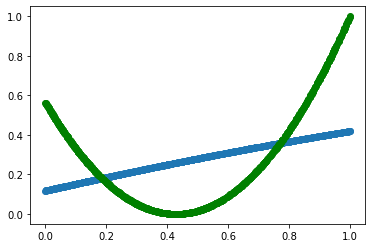

In [186]:
plt.scatter(x_train, nn.predict(x_train))
plt.scatter(x_train, y_train, color="green")